In [63]:
import os.path
import skimage.io as io
import sys
import math
import statistics as st
# import opencv
import numpy as np
from matplotlib import pyplot as plt

from skimage.transform import rotate

from skimage.measure import *
from skimage import *

from skimage.transform import probabilistic_hough_line

from skimage.feature import *

In [91]:
testImagesPath = os.path.join(os.getcwd(), 'test', 'set0')

In [92]:
def loadImages(path, n):
    images = []
    suffix = '.png'
    for i in range(n):
        filepath = os.path.join(path, str(i) + suffix)
        images.append(io.imread(filepath, as_gray=True))
    return images

In [216]:
img_n = 6
img = loadImages(testImagesPath, img_n)

In [67]:
def main():
    if len(sys.argv) != 3:
        print("Invalid number of args! Abort.")
        exit()
        
#     _, path, n = sys.argv
    path, n = testImagesPath, 6
    images = loadImages(path, int(n))

In [68]:
def entropy(_list):
    return -sum([p * math.log(p) if p > 0 else 0 for p in _list])

In [69]:
def swap(a, b):
    c = a
    a = b
    b = c

In [95]:
def distance(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return round(math.sqrt((x1-x2)**2 + (y1-y2)**2),3)

In [96]:
# usuwa niepotrzebne białe ramki; odpal przykład niżej
# 0 - top, 1 - bottom, 2 - left, 3 - right
def dropSideBorder(arr, side, n = 2): 
    if n <= 0:
        return arr
    
    _arr = arr
    while True:
        x, y = _arr.shape
        if side == 0:
            if n >= x: return _arr
            _to_sum = _arr[n]
            _next   = _arr[1:]
        elif side == 1:
            if n >= x: return _arr
            _to_sum = _arr[-n-1]
            _next   = _arr[:-1]
        elif side == 2:
            if n >= y: return _arr
            _to_sum = _arr[:,n]
            _next   = _arr[:,1:]
        elif side == 3:
            if n >= y: return _arr
            _to_sum = _arr[:,-n-1]
            _next   = _arr[:,:-1]
            
        if np.count_nonzero(_to_sum) == 0:
            _arr = _next
        else:
            return _arr
    
    return arr
    
def dropEmptyBorders(arr, n = 2):
    a = dropSideBorder(arr, 0, n)
    b = dropSideBorder(a, 1, n)
    c = dropSideBorder(b, 2, n)
    d = dropSideBorder(c, 3, n)
    return d

In [73]:
t = np.arange(225).reshape((15,15))
t[0:2] = 0
t[-5:] = 0
t[:,0:7] = 0
t[:,-3:] = 0

# print(t)
# print()
# print(dropEmptyBorders(t, 1))

In [74]:
def placeImageInNewAreaCenter(image):
    img_x = image.shape[0]    
    img_y = image.shape[1]
    result = np.zeros((img_x*3, img_y*3))
    _x = int(img_x)  
    _y = int(img_y)
    
    result[_x:_x+img_x, _y:_y+img_y] = image
    return result

In [167]:
def reverse(l):
    a = l
    a.reverse()
    return a

In [75]:
def binImg(img):
    return np.where (img>0.0, 1.0, 0.0)

In [76]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [77]:
# robi tak fajnie, że obraz ma szerokość X równą podanemu 'n'
def normalise_img_size(img, size = 1024):
    y_scale = size / img.shape[1]
    image_resized = resize(img, (round(y_scale * img.shape[0]), size), anti_aliasing=True)
    image_resized = np.where(image_resized > 0.0, 1.0, 0.0)
    return image_resized

In [78]:
# wyznacza punkt z listy, który jest najbliżej podanego
def nearestPointTo(point, points):
    distance_list = [(distance(point, p), p) for p in points]
    _points = [p for _, p in sorted(distance_list)]
    return _points[0]

In [79]:
def get_angle(p0, p1=np.array([0,0]), p2=None):
    ''' compute angle (in degrees) for p0p1p2 corner
    Inputs:
        p0,p1,p2 - points in the form of [x,y]
    '''
    if p2 is None:
        p2 = p1 + np.array([1, 0])
    v0 = np.array(p0) - np.array(p1)
    v1 = np.array(p2) - np.array(p1)

    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return np.degrees(angle)

In [80]:
# to zasadniczo ma znaleźć punkty tworzące podstawę; na wejściu są punkty skrajne z obrazka
import itertools as it

# to w sumie już teraz nie jest używane xddd
def findBase(top, bottom, left, right):
    
    lines = [(top, left), (top, right), (bottom, left), (bottom, right)]
    
    distances_list = [(distance(p1, p2), p1, p2) for p1, p2 in lines]

    lines = [(p1, p2) for _, p1, p2 in sorted(distances_list)]
    return lines[-1]

def findBaseAngle(top, bottom, left, right):
    
    print("top, right, bottom, left ", top, right, bottom, left)
    
    lines = [(top, left), (top, right), (bottom, left), (bottom, right)]
    linesA = [(top, right, bottom), (right, bottom, left), (bottom, left, top), (left, top, right)]

    angle_list = [(abs(get_angle(p1,p2,p3) - 90), p1, p2, p3) for p1, p2, p3 in linesA]
    angle_list = [a for a in angle_list if abs(a[0]) < 25]
    print(angle_list)
    
    

    
#     distances_list = [(distance(p1, p2), p1, p2) for p1, p2 in lines]

    lines = [p2 for _, p1, p2, p3 in sorted(angle_list)]
    return lines[0:2]

In [81]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [82]:
def tupleSwap(t):
    a, b = t
    return (b,a)

In [83]:
def angle_between_2_lines(a, b):
    p1, p2 = a
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    a_angle = math.atan2((y1 - y2), (x1 - x2))

    p1, p2 = b
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    b_angle = math.atan2((y1 - y2), (x1 - x2))
    return math.degrees(abs(b_angle - a_angle)) % 90 # 0-90 deg

In [84]:
def take_longest_and_not_parallel_lines(lines):
    treshold = 45 #deg
    lines_ = sorted([(distance(p1,p2), p1, p2) for p1, p2 in lines])
    lines_ = [(p1, p2) for _, p1, p2 in lines_]
    lines_.reverse()
    lines_ = lines_[:int(len(lines_)/10)]
    
    return lines_

    result = []
    while len(lines_) > 0:
        l = lines_[0]
        result.append(l)
        if len(lines_) > 1:
            l1, l2 = l
            l_ = [(p1, p2) for p1, p2 in lines_[1:] if angle_between_2_lines((p1, p2), (l1, l2)) > treshold]
            lines_ = l_
    
    return result

In [101]:
# to nie do końca działa, pewnie w jakimś przypadku będzie trzeba dodać 180; teraz jest tylko poglądowo;
# obraz moze być do góry nogami, ale będzie przynajmniej wyrównany do OX
def degreesFromLineToXAxis(p1, p2, x_size = 256):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]

    rotate = 0
    
    return -math.degrees(math.atan2((y1 - y2), (x1 - x2))) + 90 + rotate

In [110]:
def calcImgDeterminant(img):
    result = []
    for i in range(img.shape[1]):
        result.append(np.count_nonzero(img[:,i]))
    
    return result

In [170]:
def normalise_vector(v):

    _max = np.max(v)
    _min = np.min(v)
    v = [ (x - _min)/(_max - _min) for x in v]
    return v

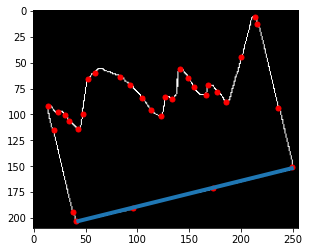

<Figure size 432x288 with 0 Axes>

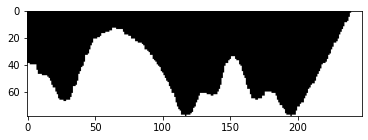

<Figure size 432x288 with 0 Axes>

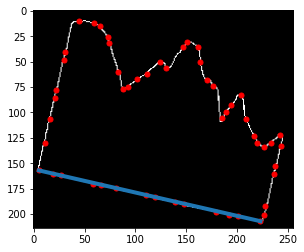

<Figure size 432x288 with 0 Axes>

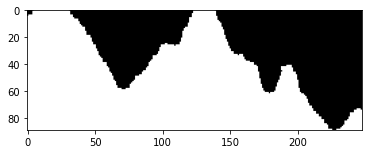

<Figure size 432x288 with 0 Axes>

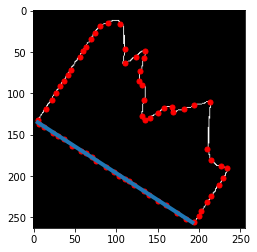

<Figure size 432x288 with 0 Axes>

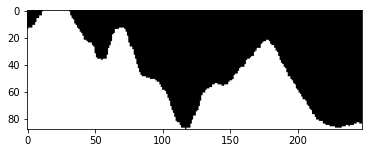

<Figure size 432x288 with 0 Axes>

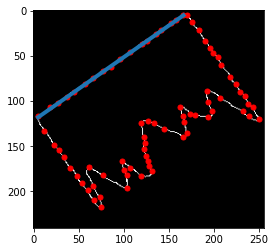

<Figure size 432x288 with 0 Axes>

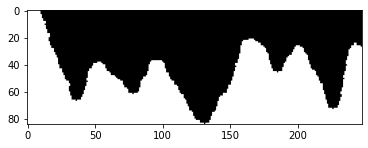

<Figure size 432x288 with 0 Axes>

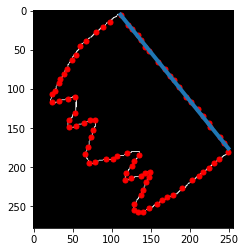

<Figure size 432x288 with 0 Axes>

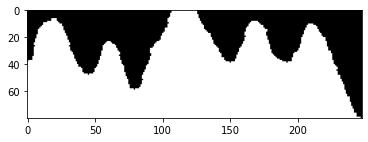

<Figure size 432x288 with 0 Axes>

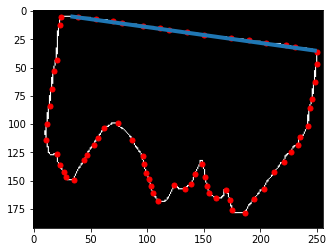

<Figure size 432x288 with 0 Axes>

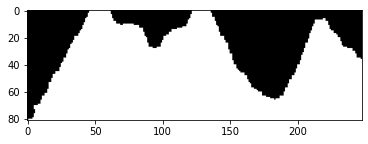

<Figure size 432x288 with 0 Axes>

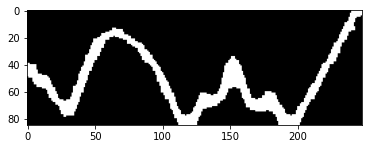

<Figure size 432x288 with 0 Axes>

For  0  best is  [5, 4, 1, 2, 3]
For  1  best is  [5, 4, 2, 3, 0]
For  2  best is  [5, 4, 1, 3, 0]
For  3  best is  [5, 4, 1, 2, 0]
For  4  best is  [5, 1, 2, 3, 0]
For  5  best is  [4, 1, 2, 3, 0]


In [243]:
from skimage.filters import gaussian
from skimage.morphology import *
determinants = []
i = 0
for image in img:
    image = dropEmptyBorders(image, 16)
    image = normalise_img_size(image, 256)

    image_traits = regionprops(img_as_int(image))[0]
    image_orig = image
    centroid = image_traits.centroid
    canny_border = canny(image)
    
    lines = probabilistic_hough_line(canny_border, threshold=32, line_length=16, line_gap=32)
    lines = take_longest_and_not_parallel_lines(lines)
    
    coords = corner_peaks(corner_harris(image), min_distance=4)
   
    # punkty jako krotki (x,y)
    points = list(zip(coords[:, 0], coords[:, 1]))

    (p1, p2) = lines[0]
    p = (p1, p2) = (tupleSwap(p1), tupleSwap(p2))
    
    # kąt do obrotu, też nie zawsze działa, bo trzeba dodać ten przypadek obrotu o 180 jeszcze
    theta = degreesFromLineToXAxis(p1, p2)

    fig, ax = plt.subplots()
#     rysuje obrazek i punkty itd
#     magenta -> podstawa
#     zielony -> obwód
    plt.imshow(canny_border, cmap=plt.cm.gray)
    plt.plot(coords[:, 1], coords[:, 0], color='red', marker='o', linestyle='None', markersize=5)

#     print(len(lines))
    for line in lines[:1]:
        p0, p1 = line
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]), linewidth=4)
#         plt.plot(p0[0], p0[1], color='lightblue', marker='+', linewidth=4, markersize=20)
    
#     plt.plot(p[:, 1], p[:, 0], color='magenta', linewidth=8, markersize=40)
#     plt.plot(pp[:, 1], pp[:, 0], color='lightgreen', linewidth=4, markersize=20)

#     plt.plot(border_points[:, 1], border_points[:, 0], color='lightblue', linewidth=4, markersize=20)
#     plt.plot(centroid[1], centroid[0], color='lightblue', marker='+', linewidth=4, markersize=20)
    plt.figure()
    plt.show()
    
    # a tu rysuje po obrocie
    x = rotate(placeImageInNewAreaCenter(image_orig), theta)
    x = dropEmptyBorders(x,2) 
    x = normalise_img_size(x, 256)
    x = x[4:-4, 4:-4]
    
#     x = opening(closing(x, star(3)), star(3))
    x = closing(x, star(3))
    
    #mockup
    if np.count_nonzero(x[-1]) < (x.shape[1]*0.75):
        x = rotate(x, 180)


        
    if i == 0:
        ____0 = x[:85]
        
    if i == 5:
        ____5 = rotate(x[:85], 180)
        
    if i == 1:
        ____1 = rotate(x[:85], 180)
        
    if i == 2:
        ____2 = rotate(x[:85], 180)
        
    while True:
        if np.count_nonzero(x[-1]) == x.shape[1]:
            x = x[:-1]
        else:
            break
        
    determinant = normalise_vector(calcImgDeterminant(x))
    determinants.append(determinant)

    plt.imshow(x, cmap=plt.cm.gray)
    plt.figure()
    plt.show()
    i += 1
    
plt.imshow(____0 * ____5, cmap=plt.cm.gray)
plt.figure()
plt.show()

# for i in range(6):
#     determinants[i] = [determinants[i][x] for x in range(len(determinants[i])) if x % 10 == 0 ]

rev_determinants = [reverse(x) for x in determinants]

#print(np.mean(determinants[0] + reverse(determinants[5])))
for i in range(img_n):
    res = sorted([(np.mean(np.subtract(determinants[i], rev_determinants[j])), j) for j in range(img_n) if i != j])
    res = [x for _, x in res]
    print("For ", i, " best is ", res)

In [190]:

#     return p1, p2
    

In [ ]:
# to nie do końca działa, pewnie w jakimś przypadku będzie trzeba dodać 180; teraz jest tylko poglądowo;
# obraz moze być do góry nogami, ale będzie przynajmniej wyrównany do OX
def degreesFromLineToXAxis(p1, p2):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    rotate = 180 if x1 > x2 else 0
    return -math.degrees(math.atan2((y1 - y2), (x1 - x2))) + 90 + rotate

In [ ]:
for image in img:
    image = dropEmptyBorders(image, 4)
    image = normalise_img_size(image, 256)

    # wyznacza te punkty charakterystyczne; tutaj się okazuje że 32 i .2 dają póki co najlepszy wynik
    coords = corner_peaks(corner_shi_tomasi(image), min_distance=16, threshold_rel=.1, exclude_border=False)
   
    # punkty jako krotki (x,y)
    points = list(zip(coords[:, 0], coords[:, 1]))
    
    # left to skrajnie lewy; top skrajnie górny punkt itd
    left = sorted([(x, (x,y)) for x, y in points])[0][1]
    right = sorted([(x, (x,y)) for x, y in points])[-1][1]
    top = sorted([(y, (x,y)) for x, y in points])[0][1]
    bottom = sorted([(y, (x,y)) for x, y in points])[-1][1]
    new_points = [right, top , left, bottom]
    
    # to tylko do wyświetlania obwodu figury
    pp = np.array([list(x) for x in [right, top , left, bottom, right]])
    
    # a to są te punkty, którze rzekomo tworzą podstawę xd
    # oczywiście to nie działa. nie zawsze
    p = [p1, p2] = np.array(list(findBase(top, bottom, left, right)))
    
    # TODO TODO TODO
    # ogólnie patent jest taki, żeby sprawdzić która prosta z dwoma innymi tworzy kąty proste
    # oczywiście w 90 st się nie wstrzelimy xd
    # więc te najlepsze trzeba będzie wziąć
    # no i rozwiązać problem taki, że np. left i top to te same punkty; gdzieś to widać niżej, 
    # że jest trójkąt zamiast prostokąta

    # kąt do obrotu, też nie zawsze działa, bo trzeba dodać ten przypadek obrotu o 180 jeszcze
    theta = degreesFromLineToXAxis(p1, p2)

    fig, ax = plt.subplots()
    # rysuje obrazek i punkty itd
    # magenta -> podstawa
    # zielony -> obwód
    plt.imshow(image, cmap=plt.cm.gray)
    plt.plot(coords[:, 1], coords[:, 0], color='red', marker='o', linestyle='None', markersize=5)
    plt.plot(p[:, 1], p[:, 0], color='magenta', linewidth=8, markersize=40)
    plt.plot(pp[:, 1], pp[:, 0], color='lightgreen', linewidth=4, markersize=20)
    plt.figure()
    plt.show()
    
    # a tu rysuje po obrocie
    # oczywiście będzie trzeba jeszcze przeskalować obraz, bo ucina trochę obracając
    x = rotate(image, theta)
    x = normalise_img_size(x, 256)
    x = dropEmptyBorders(x,1) 
    x = x[2:-2, 2:-2]
    plt.imshow(x, cmap=plt.cm.gray)
    plt.figure()
    plt.show()